In [1]:
%matplotlib inline
import pickle
import xgboost as xgb
from scipy.stats import randint as sp_randint
from time import time
import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
import imp
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
import numpy as np
from sklearn.impute import SimpleImputer
#from keras.models import Sequential
#import keras
#from keras.layers import Dropout
#from keras.layers import Dense, Activation
#from keras import optimizers
from time import time
from scipy.stats import randint as sp_randint
#from keras import regularizers
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
#import keras
import math

from Utilities import *

In [2]:
import tensorflow.keras as keras

# Utility: Load Dataframe

In [3]:
x_train_c, x_test_c, lut1, lut2 = load_clinic_data('./x_train/features/clinical_data.csv', './x_test/features/clinical_data.csv')

x_train_r, x_test_r = load_radiomic_data('./x_train/features/radiomics.csv', './x_test/features/radiomics.csv')

y_train = load_label_data('./y_train.csv')

XY_train = join_train_data(x_train_c, x_train_r, y_train)

X_test_rc, X_test_ID = load_test_data('./x_test/features/clinical_data.csv', './x_test/features/radiomics.csv', lut1, lut2)

In [6]:
X_test_ID

array([ 13, 155, 404, 407,   9,  49,  55, 200, 170, 387, 319, 119,  12,
       410,  34,  85,  50,  10,  97, 270,  38,   0,  75, 374,  99, 364,
       271,  59, 342, 125, 398, 192, 206,  41, 413, 156, 118, 363, 287,
        65, 351, 411,  54, 201, 128, 177, 260, 322, 203,  87, 415, 223,
        46,  19, 419, 360, 153, 146, 219, 234, 377, 179, 104, 217, 369,
        71, 408, 339, 281, 232, 191, 120, 230, 337,  62, 245, 167, 190,
       405, 215, 296, 324, 267, 182, 254, 301, 412, 127, 168, 326,  27,
        60,  74, 239,  80, 332, 205, 220, 289, 158,   6, 194, 136, 243,
       352,  28, 292, 265, 311, 291, 370, 379, 113, 140,   1, 207, 198,
       344, 241, 278,  66, 132, 169, 199, 274], dtype=int64)

# Exploration

## 1. radiomic features are highly correlated

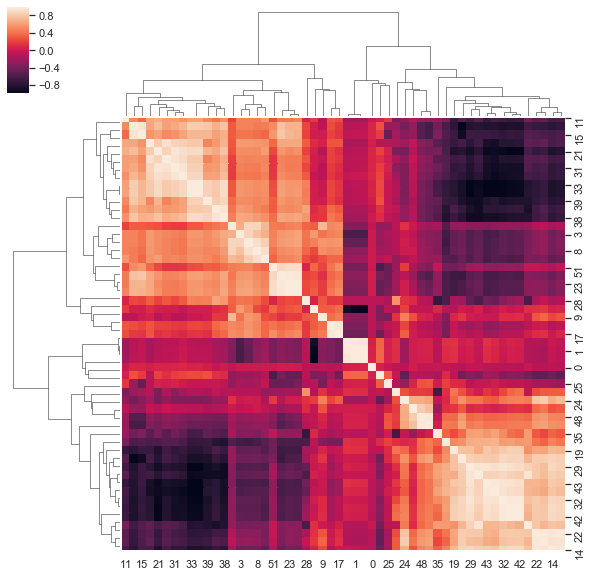

In [7]:
g = sns.clustermap(np.corrcoef(x_train_r.values, rowvar=False))

## 2. Clinic features against SurvivalTime

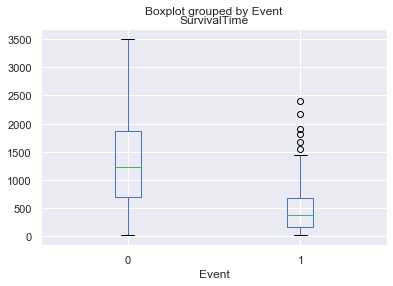

In [8]:
XY_train.boxplot(column='SurvivalTime', by='Event')

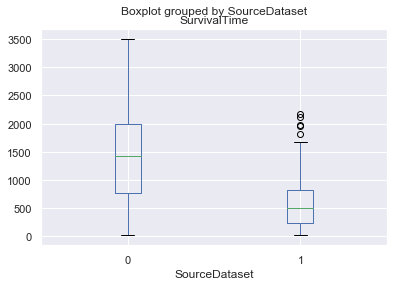

In [9]:
XY_train.boxplot(column='SurvivalTime', by='SourceDataset')

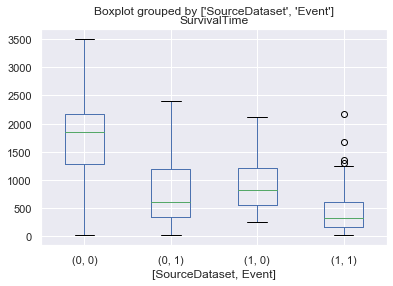

In [10]:
XY_train.boxplot(column='SurvivalTime', by=['SourceDataset','Event'])

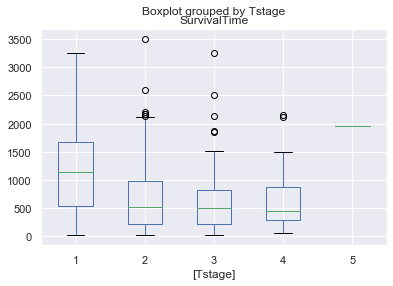

In [11]:
XY_train.boxplot(column='SurvivalTime', by=['Tstage'])

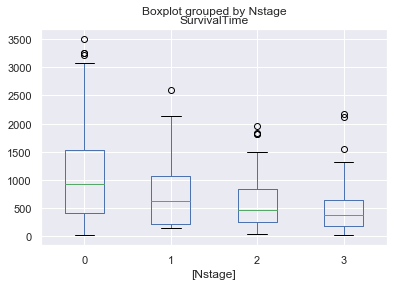

In [12]:
XY_train.boxplot(column='SurvivalTime', by=['Nstage'])

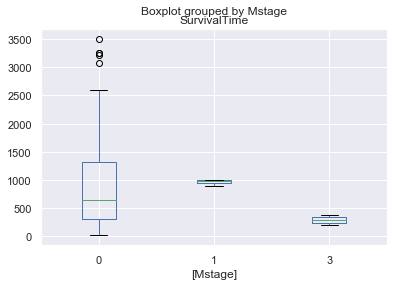

In [13]:
XY_train.boxplot(column='SurvivalTime', by=['Mstage'])

# Utility: prepare np.array

In [14]:
def prepare_train_data(df, train_slpit=250,  feature_List=None, normalize=True, threshold=None):
    X = df.drop(['SurvivalTime','Event'], axis=1)
    Y = df['SurvivalTime'].values
    Y2 = df['Event'].values

    # Feature Selection
    if feature_List is not None:
        X = X[feature_List]
    
    col_name = X.columns
    X = X.values
    
    X_train = X[:train_slpit,:]
    X_valid = X[train_slpit:,:]
    Y_train = Y[:train_slpit]
    Y_valid = Y[train_slpit:]
    Y2_train = Y2[:train_slpit]
    Y2_valid = Y2[train_slpit:]
    
    # Imputer
    imp = SimpleImputer(strategy="mean")
    X_train = imp.fit_transform(X_train)
    X_valid = imp.fit_transform(X_valid)

    # Normalize
    scr = preprocessing.StandardScaler()
    if normalize:
        X_train = scr.fit_transform(X_train)
        X_valid = scr.transform(X_valid)

    if threshold is not None:
        X_train[X_train<=-threshold]=-threshold
        X_train[X_train>=threshold]=threshold
        X_valid[X_valid<=-threshold]=-threshold
        X_valid[X_valid>=threshold]=threshold

    return X_train, X_valid, Y_train, Y_valid, Y2_train, Y2_valid, col_name, scr

In [15]:
def prepare_test_data(df, feature_list=None, normalizer=None, threshold=None):
    # Feature Selection
    X = df.copy()
    if feature_list is not None:
        X = X[feature_List]
    
    col_name = X.columns
    X = X.values

    # Imputer
    imp = SimpleImputer(strategy="mean")
    X = imp.fit_transform(X)

    # Normalize
    if normalizer is not None:
        X = scr.fit_transform(X)

    if threshold is not None:
        X[X<=-threshold]=-threshold
        X[X>=threshold]=threshold

    return X

In [16]:
X_train, X_valid, Y_train, Y_valid, Y2_train, Y2_valid, col_name, scr = prepare_train_data(XY_train, 250, None, True, 5)

X_test = prepare_test_data(X_test_rc, None, scr, None)

In [17]:
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)
print(Y2_train.shape)
print(Y_valid.shape)
print(X_test.shape)

(250, 59)
(50, 59)
(250,)
(50,)
(250,)
(50,)
(125, 59)


In [18]:
X_train_C = X_train[:,:6]
X_train_R = X_train[:,6:]
X_valid_C = X_valid[:,:6]
X_valid_R = X_valid[:,6:]
X_test_C = X_test[:,:6]
X_test_R = X_test[:,6:]
print(X_train_C.shape)
print(X_train_R.shape)
print(X_valid_C.shape)
print(X_valid_R.shape)
print(X_test_C.shape)
print(X_test_R.shape)

(250, 6)
(250, 53)
(50, 6)
(50, 53)
(125, 6)
(125, 53)


In [19]:
pca = PCA(n_components=10)
pca.fit(X_train_R)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))
X_train_PCA_R = pca.transform(X_train_R)
X_valid_PCA_R = pca.transform(X_valid_R)
X_test_PCA_R = pca.transform(X_test_R)

[0.51474517 0.15720008 0.07115965 0.0559684  0.04337431 0.0375726
 0.02454481 0.01875053 0.01756728 0.01621186]
0.9570946859445355


In [20]:
X_train_PCA = np.concatenate([X_train_C, X_train_PCA_R], axis=1)
X_valid_PCA = np.concatenate([X_valid_C, X_valid_PCA_R], axis=1)
X_test_PCA = np.concatenate([X_test_C, X_test_PCA_R], axis=1)
print(X_train_PCA.shape)
print(X_valid_PCA.shape)
print(X_test_PCA.shape)

(250, 16)
(50, 16)
(125, 16)


# Model

## XGB-survival

## CV

In [21]:

from sklearn.model_selection import cross_val_score

final_params = {'subsample': 0.8700000000000001, 'reg_lambda': 0.0005, 'reg_alpha': 0.005, 'min_child_weight': 4, 'max_depth': 2, 'colsample_bytree': 0.9000000000000001, 'colsample_bynode': 0.4, 'colsample_bylevel': 0.9000000000000001, 'n_estimators':1000,
                       'objective':'reg:squarederror',
                       'learning_rate':0.005}

reg_f = xgb.XGBRegressor(**final_params)


scores = cross_val_score(reg_f, X_train_PCA, Y_train, cv=10, scoring='neg_mean_squared_error')
scores2 = np.sqrt(-scores)
print("RMSE: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))

RMSE: 621.57 (+/- 149.82)


## Plain Model (C-INDEX)

In [22]:
from sklearn.model_selection import train_test_split
from metrics import cindex

def C_Index(y_pred, y_truth, y_df):
    y_pref_df = y_df.set_index('PatientID')[:y_pred.shape[0]].copy()
    y_truth_df = y_df.set_index('PatientID')[:y_truth.shape[0]].copy()
    y_pref_df['SurvivalTime'] = y_pred
    y_truth_df['SurvivalTime'] = y_truth

    return cindex(y_pref_df, y_truth_df)

#Xt, Xv, yt, yv = train_test_split(X_train_PCA, Y_train, test_size=0.33, random_state=42)

#print(Xt.shape)
#print(Xv.shape)
#print(yt.shape)
#print(yv.shape)

reg_f = xgb.XGBRegressor(**final_params)

reg_f.fit(X_train_PCA, Y_train)
y_predv = reg_f.predict(X_valid_PCA)
y_predt = reg_f.predict(X_train_PCA)
y_predtest = reg_f.predict(X_test_PCA)

print("TEST: ", C_Index(y_predv, Y_valid, y_train))
print("TRAIN: ", C_Index(y_predt, Y_train, y_train))

TEST:  0.6661073825391592
TRAIN:  0.8011043341646793


## Event Prediction 

In [130]:
Y2_train

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 0], dtype=int64)

In [77]:
clfe = xgb.XGBClassifier(n_estimators=1000,
                       objective='binary:logistic',
                       learning_rate=0.005,
                      )
    
param_dist = {
                    'max_depth':[2, 4, 6, 8, 10, 12],  
                    'min_child_weight':[4, 5, 6, 7, 8],

                    'subsample':np.arange(0.70, 1.00, 0.01),
                    'colsample_bytree': np.arange(0.30, 1, 0.1), 
                    'colsample_bylevel': np.arange(0.30, 1, 0.1),
                    'colsample_bynode': np.arange(0.30, 1, 0.1),
                    'reg_alpha':[.001, .005, .0005],
                    'reg_lambda':[.001, .005, .0005],
                    }



# run randomized search
n_iter_search = 500

random_searche = RandomizedSearchCV(clfe, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, 
                                   scoring='accuracy',
                                   n_jobs =-1,
                                   verbose=2)

random_searche.fit(X_train_PCA, Y2_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  3.7min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.005,
                                           max_delta_step=0, max_depth=3,
                                           min_child_weight=1, missing=None,
                                           n_estimators=1000, n_jobs=1,
                                           nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alph...
                                        'min_child_weight': [4, 5, 6, 7, 8],
                                        'reg_alpha': [0.001, 0.005, 0.0005],
                         

In [78]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(random_searche.cv_results_, 5)     

Model with rank: 1
Mean validation score: 0.660 (std: 0.022)
Parameters: {'subsample': 0.9400000000000002, 'reg_lambda': 0.005, 'reg_alpha': 0.0005, 'min_child_weight': 4, 'max_depth': 10, 'colsample_bytree': 0.3, 'colsample_bynode': 0.8000000000000003, 'colsample_bylevel': 0.5}

Model with rank: 2
Mean validation score: 0.656 (std: 0.023)
Parameters: {'subsample': 0.9600000000000002, 'reg_lambda': 0.001, 'reg_alpha': 0.001, 'min_child_weight': 4, 'max_depth': 12, 'colsample_bytree': 0.3, 'colsample_bynode': 0.8000000000000003, 'colsample_bylevel': 0.6000000000000001}

Model with rank: 2
Mean validation score: 0.656 (std: 0.023)
Parameters: {'subsample': 0.9900000000000002, 'reg_lambda': 0.001, 'reg_alpha': 0.0005, 'min_child_weight': 4, 'max_depth': 10, 'colsample_bytree': 0.3, 'colsample_bynode': 0.8000000000000003, 'colsample_bylevel': 0.6000000000000001}

Model with rank: 4
Mean validation score: 0.652 (std: 0.037)
Parameters: {'subsample': 0.8200000000000001, 'reg_lambda': 0.0005,

In [23]:
event_params = {'subsample': 0.9400000000000002, 
                'reg_lambda': 0.005, 'reg_alpha': 0.0005,
                'min_child_weight': 4, 'max_depth': 10,
                'colsample_bytree': 0.3, 
                'colsample_bynode': 0.8, 
                'colsample_bylevel': 0.5,
                'n_estimators':1000,
               'objective':'binary:logistic',
               'learning_rate':0.005}

reg_e = xgb.XGBClassifier(**event_params)

scores = cross_val_score(reg_e, X_train_PCA, Y2_train, cv=10, scoring='accuracy')

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.62 (+/- 0.14)


In [24]:
reg_e = xgb.XGBClassifier(**event_params)
reg_e.fit(X_train_PCA, Y2_train)
X_train_Event = reg_e.predict(X_train_PCA)
X_valid_Event = reg_e.predict(X_valid_PCA)
X_test_Event = reg_e.predict(X_test_PCA)

## Stacked Event+Survival Predict

In [25]:

X_train_PCAE = np.concatenate([X_train_PCA, X_train_Event.reshape(-1,1)], axis=1)
X_valid_PCAE = np.concatenate([X_valid_PCA, X_valid_Event.reshape(-1,1)], axis=1)
X_test_PCAE = np.concatenate([X_test_PCA, X_test_Event.reshape(-1,1)], axis=1)
print(X_test_PCAE.shape)
print(X_valid_PCAE.shape)
print(X_train_PCAE.shape)

(125, 17)
(50, 17)
(250, 17)


In [26]:

from sklearn.model_selection import cross_val_score

final_params = {'subsample': 0.9900000000000002, 'reg_lambda': 0.001, 'reg_alpha': 0.001, 'min_child_weight': 4, 'max_depth': 2, 'colsample_bytree': 0.9000000000000001, 'colsample_bynode': 0.4, 'colsample_bylevel': 0.7000000000000002,
     'objective':'reg:squarederror',
                       'learning_rate':0.005,
               'n_estimators':1000}

reg_f = xgb.XGBRegressor(**final_params)


scores = cross_val_score(reg_f, X_train_PCAE, Y_train, cv=10, scoring='neg_mean_squared_error')
scores2 = np.sqrt(-scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))



Accuracy: 587.22 (+/- 152.06)


In [90]:
clf = xgb.XGBRegressor(n_estimators=1000,
                       objective='reg:squarederror',
                       learning_rate=0.005)

    
param_dist = {'max_depth':[2, 4, 6, 8, 10, 12],  
                    'min_child_weight':[4, 5, 6, 7, 8],
                    'subsample':np.arange(0.70, 1.00, 0.01),
                    'colsample_bytree': np.arange(0.30, 1, 0.1), 
                    'colsample_bylevel': np.arange(0.30, 1, 0.1),
                    'colsample_bynode': np.arange(0.30, 1, 0.1),
                    'reg_alpha':[.001, .005, .0005],
                    'reg_lambda':[.001, .005, .0005]}
                       
n_iter_search = 1000
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, 
                                   scoring='neg_mean_squared_error',
                                   n_jobs =-1,
                                   verbose=2)

random_search.fit(X_train_PCAE, Y_train)


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 10.5min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.005, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=1000,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',...
                                        'reg_alpha': [0.001, 0.005, 0.0005],
                                        'reg_lambda': [0.001, 0.005, 0.0005],
                                        'subsample': array([0.7 , 0.71, 0.72,

In [92]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(random_search.cv_results_, 5)           



Model with rank: 1
Mean validation score: -325292.028 (std: 70199.437)
Parameters: {'subsample': 0.9900000000000002, 'reg_lambda': 0.001, 'reg_alpha': 0.001, 'min_child_weight': 4, 'max_depth': 2, 'colsample_bytree': 0.9000000000000001, 'colsample_bynode': 0.4, 'colsample_bylevel': 0.7000000000000002}

Model with rank: 2
Mean validation score: -325905.361 (std: 68905.192)
Parameters: {'subsample': 0.9900000000000002, 'reg_lambda': 0.001, 'reg_alpha': 0.005, 'min_child_weight': 4, 'max_depth': 2, 'colsample_bytree': 0.6000000000000001, 'colsample_bynode': 0.9000000000000001, 'colsample_bylevel': 0.4}

Model with rank: 3
Mean validation score: -326750.242 (std: 67077.468)
Parameters: {'subsample': 0.9600000000000002, 'reg_lambda': 0.005, 'reg_alpha': 0.005, 'min_child_weight': 4, 'max_depth': 2, 'colsample_bytree': 0.9000000000000001, 'colsample_bynode': 0.6000000000000001, 'colsample_bylevel': 0.5}

Model with rank: 4
Mean validation score: -328013.297 (std: 73951.175)
Parameters: {'sub

In [27]:
from sklearn.model_selection import train_test_split
from metrics import cindex

def C_Index(y_pred, y_truth, y_df):
    y_pref_df = y_df.set_index('PatientID')[:y_pred.shape[0]].copy()
    y_truth_df = y_df.set_index('PatientID')[:y_truth.shape[0]].copy()
    y_pref_df['SurvivalTime'] = y_pred
    y_truth_df['SurvivalTime'] = y_truth

    return cindex(y_pref_df, y_truth_df)

reg_f = xgb.XGBRegressor(**final_params)

reg_f.fit(X_train_PCAE, Y_train)
y_predv = reg_f.predict(X_valid_PCAE)
y_predt = reg_f.predict(X_train_PCAE)
y_predtest = reg_f.predict(X_test_PCAE)

print("TEST: ", C_Index(y_predv, Y_valid, y_train))
print("TRAIN: ", C_Index(y_predt, Y_train, y_train))

TEST:  0.6727879799553792
TRAIN:  0.7927854508017531


## CNN

In [28]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1394121926999660699
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3188470579
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13818465059866178731
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [32]:
PID = y_train['PatientID'].values
X_CT = np.zeros([300,92,92,92])
X_ROI = np.zeros([300,92,92,92])
for i, pid in enumerate(PID):
    image = np.load('./x_train/images/patient_{:03}.npz'.format(pid))
    X_CT[i,:,:,:] = (image['scan']/1024.)+1.0
    X_ROI[i,:,:,:] = image['mask']
#X_CT = np.multiply(X_CT,X_ROI)
X_CT = X_CT.reshape(-1,92,92,92)



In [118]:
X_CT_test = np.zeros([len(X_test_ID),92,92,92])
X_ROI_test = np.zeros([len(X_test_ID),92,92,92])

for i, pid in enumerate(X_test_ID):
    image = np.load('./x_test/images/patient_{:03}.npz'.format(pid))
    X_CT_test[i,:,:,:] = (image['scan']/1024.)+1.0
    X_ROI_test[i,:,:,:] = image['mask']


In [34]:
X_CT_train = X_CT[:250]
X_CT_valid = X_CT[250:]
X_ROI_train = X_ROI[:250]
X_ROI_valid = X_ROI[250:]
print(X_CT_train.shape)
print(X_CT_valid.shape)
print(X_ROI_train.shape)
print(X_ROI_valid.shape)

(250, 92, 92, 92)
(50, 92, 92, 92)
(250, 92, 92, 92)
(50, 92, 92, 92)


## CNN as predictor

In [128]:
model = keras.models.load_model('CNN2.h5')


In [119]:
Y_predCNN_train = model.predict([X_CT_train, X_ROI_train])
Y_predCNN_valid = model.predict([X_CT_valid, X_ROI_valid])
Y_predCNN_test = model.predict([X_CT_test, X_ROI_test])

In [120]:
print("TEST: ", C_Index(Y_predCNN_valid, Y_valid, y_train))
print("TRAIN: ", C_Index(Y_predCNN_train, Y_train, y_train))

TEST:  0.732689210938282
TRAIN:  0.7802214168689965


In [126]:
X_test_Event

array([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int64)

In [127]:
submission = pd.read_csv('./random_submission_0vhlEZN.csv')
submission['SurvivalTime'] = Y_predCNN_test
submission['Event'] = X_test_Event
submission.to_csv('./submission.csv', index=False)

In [37]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 92, 92, 92)] 0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 92, 92, 92)] 0                                            
__________________________________________________________________________________________________
CONV3D_B1_L1_CT (Conv2D)        (None, 90, 90, 16)   13264       input_25[0][0]                   
__________________________________________________________________________________________________
CONV3D_B1_L1_ROI1 (Conv2D)      (None, 90, 90, 16)   13264       input_26[0][0]                   
___________________________________________________________________________________________

## CNN as feature extractor

In [129]:
feature_extractor = keras.Model(inputs=model.input,
                               outputs=model.get_layer('FC2').output)

X_train_CNN = feature_extractor.predict([X_CT_train, X_ROI_train], verbose=1)
X_valid_CNN = feature_extractor.predict([X_CT_valid, X_ROI_valid] , verbose=1)
X_test_CNN = feature_extractor.predict([X_CT_test, X_ROI_test] , verbose=1)

125/125 [==============================] - 5s 40ms/sample


In [130]:
print(X_train_CNN.shape)
print(X_valid_CNN.shape)
X_train_PCAECNN = np.concatenate([X_train_PCAE, X_train_CNN], axis=1)
X_valid_PCAECNN = np.concatenate([X_valid_PCAE, X_valid_CNN], axis=1)
X_test_PCAECNN = np.concatenate([X_test_PCAE, X_test_CNN], axis=1)
#X_test_PCAE = np.concatenate([X_test_PCA, X_test_Event.reshape(-1,1)], axis=1)
#print(X_test_PCAE.shape)
print(X_train_PCAECNN.shape)
print(X_valid_PCAECNN.shape)
print(X_test_PCAECNN.shape)

(250, 5)
(50, 5)
(250, 22)
(50, 22)
(125, 22)


In [131]:

from sklearn.model_selection import cross_val_score

final_params = {'subsample': 0.9900000000000002, 'reg_lambda': 0.001, 'reg_alpha': 0.001, 'min_child_weight': 4, 'max_depth': 2, 'colsample_bytree': 0.9000000000000001, 'colsample_bynode': 0.4, 'colsample_bylevel': 0.7000000000000002,
     'objective':'reg:squarederror',
                       'learning_rate':0.005,
               'n_estimators':1000}

reg_f = xgb.XGBRegressor(**final_params)


scores = cross_val_score(reg_f, X_train_PCAECNN, Y_train, cv=10, scoring='neg_mean_squared_error')
scores2 = np.sqrt(-scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))



Accuracy: 543.85 (+/- 136.70)


In [42]:
clf = xgb.XGBRegressor(n_estimators=1000,
                       objective='reg:squarederror',
                       learning_rate=0.005)

    
param_dist = {'max_depth':[2, 4, 6, 8, 10, 12],  
                    'min_child_weight':[4, 5, 6, 7, 8],
                    'subsample':np.arange(0.70, 1.00, 0.01),
                    'colsample_bytree': np.arange(0.30, 1, 0.1), 
                    'colsample_bylevel': np.arange(0.30, 1, 0.1),
                    'colsample_bynode': np.arange(0.30, 1, 0.1),
                    'reg_alpha':[.001, .005, .0005],
                    'reg_lambda':[.001, .005, .0005]}
                       
n_iter_search = 200
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, 
                                   scoring='neg_mean_squared_error',
                                   n_jobs =-1,
                                   verbose=2)

random_search.fit(X_train_PCAECNN, Y_train)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.005, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=1000,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',...
                                        'reg_alpha': [0.001, 0.005, 0.0005],
                                        'reg_lambda': [0.001, 0.005, 0.0005],
                                        'subsample': array([0.7 , 0.71, 0.72,

In [44]:

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(random_search.cv_results_, 5)  

Model with rank: 1
Mean validation score: -293573.676 (std: 62660.475)
Parameters: {'subsample': 0.8300000000000001, 'reg_lambda': 0.005, 'reg_alpha': 0.0005, 'min_child_weight': 8, 'max_depth': 2, 'colsample_bytree': 0.8000000000000003, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.9000000000000001}

Model with rank: 2
Mean validation score: -294055.260 (std: 62976.449)
Parameters: {'subsample': 0.73, 'reg_lambda': 0.001, 'reg_alpha': 0.005, 'min_child_weight': 7, 'max_depth': 2, 'colsample_bytree': 0.9000000000000001, 'colsample_bynode': 0.4, 'colsample_bylevel': 0.9000000000000001}

Model with rank: 3
Mean validation score: -294222.942 (std: 61945.251)
Parameters: {'subsample': 0.8500000000000001, 'reg_lambda': 0.005, 'reg_alpha': 0.0005, 'min_child_weight': 4, 'max_depth': 2, 'colsample_bytree': 0.5, 'colsample_bynode': 0.8000000000000003, 'colsample_bylevel': 0.9000000000000001}

Model with rank: 4
Mean validation score: -294520.202 (std: 58648.432)
Parameters: {'subsample': 0.8

In [132]:
final_params =  {'subsample': 0.8300000000000001, 
                 'reg_lambda': 0.005, 'reg_alpha': 0.0005, 
                 'min_child_weight': 8, 'max_depth': 2, 
                 'colsample_bytree': 0.8000000000000003, 
                 'colsample_bynode': 0.5, 'colsample_bylevel': 0.9000000000000001,
                 'objective':'reg:squarederror',
                 'learning_rate':0.005,
                 'n_estimators':1000}


reg_f = xgb.XGBRegressor(**final_params)

reg_f.fit(X_train_PCAECNN, Y_train)
y_predv = reg_f.predict(X_valid_PCAECNN)
y_predt = reg_f.predict(X_train_PCAECNN)
y_predtest = reg_f.predict(X_test_PCAECNN)

print("TEST: ", C_Index(y_predv, Y_valid, y_train))
print("TRAIN: ", C_Index(y_predt, Y_train, y_train))

TEST:  0.7097844112651777
TRAIN:  0.8093989686697537


In [144]:
RFECV = [False, False, False,  True, False, False, False, False, False, False, False, False,
 False, False, False, False,  True, False, False, False, False,  True]
mask = np.array([i for i, x in enumerate(RFECV) if x])

In [145]:
X_valid_PCAECNN[:, b].shape

reg_f.fit(X_train_PCAECNN[:,mask], Y_train)
y_predv = reg_f.predict(X_valid_PCAECNN[:,mask])
y_predt = reg_f.predict(X_train_PCAECNN[:,mask])
y_predtest = reg_f.predict(X_test_PCAECNN[:,mask])

print("TEST: ", C_Index(y_predv, Y_valid, y_train))
print("TRAIN: ", C_Index(y_predt, Y_train, y_train))

TEST:  0.7346600331553125
TRAIN:  0.7872261499516509


In [149]:
y_predtest

array([ 346.65372, 1064.685  ,  233.61644,  247.7301 , 1072.588  ,
       1055.3496 , 1296.6934 ,  611.98444,  494.1197 ,  337.38748,
       1404.221  , 1367.6584 ,  651.3705 , 1042.114  ,  338.8998 ,
        339.57632,  408.38492,  583.1185 ,  337.59836, 1525.1248 ,
       1761.581  , 1484.4789 ,  908.7521 ,  512.61884, 1339.7408 ,
        651.01135,  337.38748,  652.34796,  338.8998 , 1879.7245 ,
        356.1612 , 1455.8309 ,  962.5255 ,  525.63885, 1063.2516 ,
        356.99088,  247.7301 ,  348.80945,  346.65372,  494.1197 ,
        350.02405, 1879.7245 ,  356.99088, 1448.4227 ,  526.38727,
       2044.2516 ,  356.1612 ,  902.2375 , 2006.8749 , 1369.1613 ,
        962.5255 ,  233.61644,  652.201  ,  494.1197 ,  644.8954 ,
       1095.4565 ,  494.1197 ,  335.57483,  545.6859 ,  233.61644,
        844.1157 ,  336.25775, 1062.8346 ,  338.8998 , 1487.6722 ,
        336.31775, 1455.8309 ,  882.5603 ,  233.61644,  651.3705 ,
        337.43466,  356.1612 ,  653.31195, 1338.8423 , 1367.65

In [146]:
submission = pd.read_csv('./random_submission_0vhlEZN.csv')
submission['SurvivalTime'] = y_predtest
submission['Event'] = X_test_Event
submission.to_csv('./submission.csv', index=False)

## CNN feature + Clinic + Radiomics

In [106]:
from tensorflow.keras.layers import Input, Dense, Multiply
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping


Input_CT = Input(shape=X_CT_train.shape[1:])
Input_ROI = Input(shape=X_ROI.shape[1:])
#Input_CR = Input(shape=(X_train_PCA.shape[1],))

#L1 = Multiply()([Input_CT, Input_ROI])

CT1 = Conv2D(filters=16, kernel_size=(3,3), padding='valid', activation='relu', name='CONV3D_B1_L1_CT')(Input_CT)
CT1 = Conv2D(filters=16, kernel_size=(3,3), padding='valid', activation='relu', name='CONV3D_B1_L2_CT')(CT1)
CT1 = Conv2D(filters=16, kernel_size=(3,3), padding='valid', activation='relu', name='CONV3D_B1_L3_CT')(CT1)

ROI1 = Conv2D(filters=16, kernel_size=(3,3), padding='valid', activation='relu', name='CONV3D_B1_L1_ROI1')(Input_ROI)
ROI1 = Conv2D(filters=16, kernel_size=(3,3), padding='valid', activation='relu', name='CONV3D_B1_L2_ROI1')(ROI1)
ROI1 = Conv2D(filters=16, kernel_size=(3,3), padding='valid', activation='relu', name='CONV3D_B1_L3_ROI1')(ROI1)

L2 = Multiply()([CT1, ROI1])

L2 = MaxPooling2D(pool_size=(2,2), name='MP3D_CT')(L2)


#L2 = tf.keras.backend.concatenate([CT4, ROI4], axis=4)

#L2 = MaxPooling2D(pool_size=(2,2), name='MP1')(L2)
L2 = Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu',  name='CONV2D_B2_L1_CT')(L2)
L2 = Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu',  name='CONV2D_B2_L2_CT')(L2)
L2 = Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu',  name='CONV2D_B2_L3_CT')(L2)

L3 = MaxPooling2D(pool_size=(2,2), name='MP2')(L2)


L3 = Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu',  name='CONV2D_B3_L1_CT')(L3)
L3 = Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu',  name='CONV2D_B3_L2_CT')(L3)
L3 = Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu',  name='CONV2D_B3_L3_CT')(L3)

L4 = MaxPooling2D(pool_size=(2,2), name='MP4')(L3)

L4 = Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu',  name='CONV2D_B4_L1_CT')(L4)
L4 = Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu',  name='CONV2D_B4_L2_CT')(L4)

F1 = Flatten()(L4)

F1 = Dense(256, activation='relu', name='FC1')(F1)
##F1 = BatchNormalization() (F1)
#F1 = Dropout(0.5)(F1)
#F2 = tf.keras.backend.concatenate([F1, Input_CR], axis=1)


#F2 = Dense(128, activation='relu', name='FC2')(F2)
F2 = Dense(8, activation='relu', name='FC2')(F1)

##F2 = BatchNormalization() (F2)
#F2 = Dropout(0.5)(F2)

Y = Dense(1, activation=None, name='Out')(F2)
#YE = Dense(1, activation='sigmoid', name='aux_output')(F2)

model2 = Model(inputs=[Input_CT, Input_ROI], outputs=[Y])
model2.compile(
        loss=[tf.keras.losses.mean_squared_error],
        optimizer='adam', 
        metrics={'Out':'mse'})

"""model = Model(inputs=[Input_CT, Input_ROI], outputs=[YE])
model.compile(
        loss=[tf.keras.losses.binary_crossentropy],
        optimizer='adam', 
        metrics={'aux_output':'accuracy'})"""


"model = Model(inputs=[Input_CT, Input_ROI], outputs=[YE])\nmodel.compile(\n        loss=[tf.keras.losses.binary_crossentropy],\n        optimizer='adam', \n        metrics={'aux_output':'accuracy'})"

In [107]:
model2.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 92, 92, 92)] 0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 92, 92, 92)] 0                                            
__________________________________________________________________________________________________
CONV3D_B1_L1_CT (Conv2D)        (None, 90, 90, 16)   13264       input_27[0][0]                   
__________________________________________________________________________________________________
CONV3D_B1_L1_ROI1 (Conv2D)      (None, 90, 90, 16)   13264       input_28[0][0]                   
____________________________________________________________________________________________

In [112]:
hist = model2.fit(x=[X_CT_train, X_ROI_train], y=[Y_train], batch_size=16, epochs=8, verbose=1, callbacks=None, validation_data=([X_CT_valid, X_ROI_valid], Y_valid), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False)

Train on 250 samples, validate on 50 samples
Epoch 1/8
250/250 [==============================] - 13s 51ms/sample - loss: 421855.5058 - mse: 421855.5312 - val_loss: 663018.2450 - val_mse: 663018.2500
Epoch 2/8
250/250 [==============================] - 9s 36ms/sample - loss: 493209.7985 - mse: 493209.8125 - val_loss: 507778.9387 - val_mse: 507778.9688
Epoch 3/8
250/250 [==============================] - 11s 44ms/sample - loss: 405432.2745 - mse: 405432.2812 - val_loss: 693182.5100 - val_mse: 693182.5000
Epoch 4/8
250/250 [==============================] - 10s 42ms/sample - loss: 420191.7672 - mse: 420191.7500 - val_loss: 595036.8000 - val_mse: 595036.8125
Epoch 5/8
250/250 [==============================] - 11s 43ms/sample - loss: 452485.0795 - mse: 452485.0938 - val_loss: 801291.6300 - val_mse: 801291.6875
Epoch 6/8
250/250 [==============================] - 10s 38ms/sample - loss: 400133.2040 - mse: 400133.1875 - val_loss: 763506.9200 - val_mse: 763506.9375
Epoch 7/8
250/250 [=======

In [113]:
Y_predCNN_train = model2.predict([X_CT_train, X_ROI_train])
Y_predCNN_valid = model2.predict([X_CT_valid, X_ROI_valid])

In [114]:
print("TEST: ", C_Index(Y_predCNN_valid, Y_valid, y_train))
print("TRAIN: ", C_Index(Y_predCNN_train, Y_train, y_train))

TEST:  0.6593749999896973
TRAIN:  0.7778356137216053


## Feature Selection


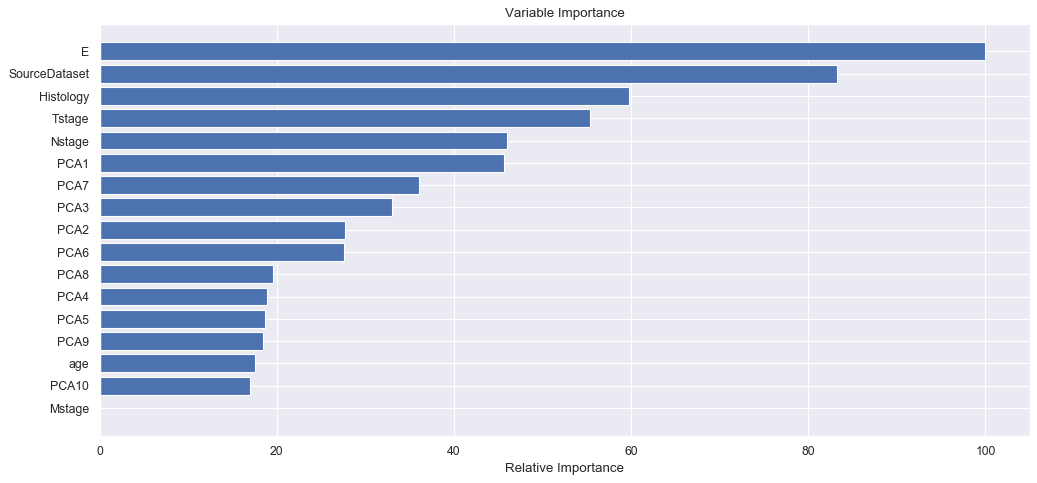

In [103]:
# Plot feature importance
feature_importance = reg_f.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig=plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2, 1, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(col)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [102]:
col = list(col_name[:6])+['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9','PCA10',"E"]
col

['Histology',
 'Mstage',
 'Nstage',
 'SourceDataset',
 'Tstage',
 'age',
 'PCA1',
 'PCA2',
 'PCA3',
 'PCA4',
 'PCA5',
 'PCA6',
 'PCA7',
 'PCA8',
 'PCA9',
 'PCA10',
 'E']

## RFECV

In [133]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV


#params = {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 5, 
#         'min_samples_split': 17, 'min_weight_fraction_leaf': 0, 'n_estimators': 500, 'subsample': 0.7}


clf = xgb.XGBRegressor(**final_params)

rfecv = RFECV(estimator=clf, step=1, cv=5, scoring='neg_mean_squared_error',verbose = True)   #5-fold cross-validation
rfecv = rfecv.fit(X_train_PCAECNN, Y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', rfecv.support_)

Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.


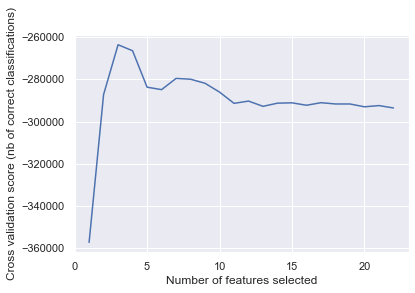

In [134]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()